

# WebScraping with Selenium

This notebook shows how use selenium to scrape data from DoveVivo.com
The scope is only to understand the capabilities of web scraping and prepare a dataset for research purporse.

Let’s begin writing our scraper!

We will first install important modules and packages for our Notebook


*   Selenium
*   Chromium-chromedriver



In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium==4.9.1

Executing: /tmp/apt-key-gpghome.pmbV75t6IN/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.WCuhuF1fCK/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.YK8rBRdIb3/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Hit:2 http://archive.ubuntu.com/ubuntu 

And now we will import some modules on our Notebook


1.   sys: to setup the path of chrome driver
2.   **selenium**: to emulate the user behaviour
3.   **pandas**: to work with data
4.   tqdm: to show a progress bar in our notebook
5.   json: to work with json format





In [ ]:
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from tqdm.notebook import tqdm
import pandas
import json
import pprint

Note: if you want to run your scraper locally please:
1. Download ChromeDriver [https://chromedriver.chromium.org/downloads](https://chromedriver.chromium.org/downloads)
2. Import these libs

```
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
from selenium import webdriver
from selenium.webdriver.common.by import By
from tqdm import tqdm_notebook as tqdm
import pandas
import json
import pprint
```
3. Create your ChromeDriver
```
wd = webdriver.Chrome('<path where you stored chromedriver>/chromedriver',chrome_options=chrome_options)
```

First we need to set the options for the ghost browser.

The most important is `--headless` because we are in a "cloud" ntotebook on Google Colab.

In our local notebook we can remove the `--headless` option.


In [ ]:
chrome_options = webdriver.ChromeOptions()

chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("window-size=1900,800")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36")

`webdriver` is the most importa object in Selenium.
With `webdriver` we can start the phantom browser, emulate the user navigation and scrape our data.

Let’s now create a new instance of google chrome.


We will navitage to page by a `get` request. With http we can do a get or a post (or others but they are not important for us): https://www.w3schools.com/tags/ref_httpmethods.asp



```
wd.get("https://www.dovevivo.com/en/rent-room-bologna/")
```



What does **user agent** mean??
[https://en.wikipedia.org/wiki/User_agent](https://en.wikipedia.org/wiki/User_agent) and [https://www.w3.org/WAI/UA/work/wiki/Definition_of_User_Agent](https://www.w3.org/WAI/UA/work/wiki/Definition_of_User_Agent)


> A user agent is any software that retrieves and presents Web content for end users or is implemented using Web technologies. User agents include Web browsers, media players, and plug-ins that help in retrieving, rendering and interacting with Web content.

In our case we are using the mark of "Mozilla/5.0...." to emulate a Chrome Browser.

You can find a valid user agent signature here:
[https://developers.whatismybrowser.com/useragents/explore/](https://developers.whatismybrowser.com/useragents/explore/)

In some case is better to user a specific user agent to infor the scraped web site:
> I am a bot, and I am scraping you



## First connection

In [ ]:
webdriver.__version__

'4.9.1'

In [ ]:
wd = webdriver.Chrome('chromedriver', options=chrome_options)

In [ ]:
wd.get("https://www.dovevivo.com/en/rent-room-bologna/")

Take a look to the screenshot from our phantom browser.

Note:
- la language and the locale: It is en_US but we are coming from different locale
- the screen ratio: is it the same of our notebook?

Populating the interactive namespace from numpy and matplotlib


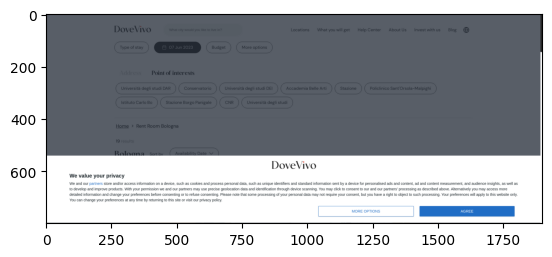

In [ ]:
wd.save_screenshot('screenshot.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/screenshot.png')
imgplot = plt.imshow(img)
plt.show()

Let's try to extract some information from the page



`title` contains the title of our page.




In [ ]:
print(wd.title)

Rooms for rent in Bologna for students and workers | DoveVivo


### First exercise with *Selenium*

Try it yourself... Print the contents of the page on the screen!

Complete the code and annotate the different behaviour.

Try to use the attributes/methods applied to `wd`

- `page_source`
- `find_elements`




In [ ]:
print(....)

### How do we extract the values inside a page with CSS Selector?

Selenium has a method called `find_elements`.

We will pass our CSS Selector into this method and get a list of selenium elements.

Once we have the element, we can extract the text inside it using the `text` function.

In [ ]:
list_titles = wd.find_elements(By.CSS_SELECTOR, ".Content__Title-sc-5e5rf1-0")
print(len(list_titles))

12


In [ ]:
print(list_titles[0].text)
print(list_titles[1].text)

Comfy single room
Cosy single room


### Exercise on *find_elements*

Try to export the list of `.Content__Address-sc-5e5rf1-1` elements and show the content of the first element.


**Scope: get the address of the rooms**




In [ ]:
list_address = wd......(By.CSS_SELECTOR, "...")
print(len(list_address))

# Room List from DoveVivo

Let's begin to download the list of rooms.

The list of rooms is defined by the css selection rule
`div.CardRoom__Outer-sc-hz5kaa-0`



In [ ]:
list_rooms = wd.find_elements(By.CSS_SELECTOR,"div.CardRoom__Outer-sc-hz5kaa-0")
print(len(list_rooms))

12


Gread! We find 12 rooms!

Now, we will extract the attribute from each single element.
The scope is to create one dict for each room in the list with the attribute:


1.   url
2.   title
3.   price
4.   availability
5.   address



In [ ]:
import pprint
details = []
for item in list_rooms:
    url = item.find_elements(By.CSS_SELECTOR,"a")[0].get_attribute("href")
    title = ""
    address = ""
    price = ""
    discount_price = ""
    availability = ""
    if(len(item.find_elements(By.CSS_SELECTOR,".Content__Title-sc-5e5rf1-0")) > 0):
      title = item.find_elements(By.CSS_SELECTOR,".Content__Title-sc-5e5rf1-0")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".Content__PriceContainer-sc-5e5rf1-3")) > 0):
      price = item.find_elements(By.CSS_SELECTOR,".Content__PriceContainer-sc-5e5rf1-3")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".DiscountPrice__BasePrice-sc-y7v2mo-2")) > 0):
      price = item.find_elements(By.CSS_SELECTOR,".DiscountPrice__BasePrice-sc-y7v2mo-2")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".DiscountPrice__PromoPrice-sc-y7v2mo-3")) > 0):
      discount_price = item.find_elements(By.CSS_SELECTOR,".DiscountPrice__PromoPrice-sc-y7v2mo-3")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".Content__Address-sc-5e5rf1-1")) > 0):
      address = item.find_elements(By.CSS_SELECTOR,".Content__Address-sc-5e5rf1-1")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".AvailableFrom__Date-sc-iqwzgh-0")) > 0):
      availability = item.find_elements(By.CSS_SELECTOR,".AvailableFrom__Date-sc-iqwzgh-0")[0].text

    details.append({'url': url,
                    'title': title,
                    'address': address,
                    'availability': availability,
                    'price': price,
                    'discount_price': discount_price})


In [ ]:
len(details)
pprint.pprint(details[0:2])

[{'address': 'Bologna | Via Benedetto Marcello | Bus 11 103m',
  'availability': 'Available',
  'discount_price': '410€/month',
  'price': '630€',
  'title': 'Comfy single room',
  'url': 'https://www.dovevivo.com/en/rent-studio-bologna-via-benedetto-marcello/bo-0018-04-a/'},
 {'address': 'Bologna | Piazza Trento Trieste | Bus 62 111m',
  'availability': 'Available',
  'discount_price': '445€/month',
  'price': '680€',
  'title': 'Cosy single room',
  'url': 'https://www.dovevivo.com/en/rent-studio-bologna-piazza-trento-trieste/bo-0014-03-a/'}]


Now let's try downloading all the ads on the front page...
and then move on to the second page...

First we define a `parse_item` function to make the code cleaner and to reuse the function.

In [ ]:
def parse_item(item, city):
    url = item.find_elements(By.CSS_SELECTOR,"a")[0].get_attribute("href")
    title = ""
    address = ""
    price = ""
    discount_price = ""
    availability = ""
    if(len(item.find_elements(By.CSS_SELECTOR,".Content__Title-sc-5e5rf1-0")) > 0):
      title = item.find_elements(By.CSS_SELECTOR,".Content__Title-sc-5e5rf1-0")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".Content__PriceContainer-sc-5e5rf1-3")) > 0):
      price = item.find_elements(By.CSS_SELECTOR,".Content__PriceContainer-sc-5e5rf1-3")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".DiscountPrice__BasePrice-sc-y7v2mo-2")) > 0):
      price = item.find_elements(By.CSS_SELECTOR,".DiscountPrice__BasePrice-sc-y7v2mo-2")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".DiscountPrice__PromoPrice-sc-y7v2mo-3")) > 0):
      discount_price = item.find_elements(By.CSS_SELECTOR,".DiscountPrice__PromoPrice-sc-y7v2mo-3")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".Content__Address-sc-5e5rf1-1")) > 0):
      address = item.find_elements(By.CSS_SELECTOR,".Content__Address-sc-5e5rf1-1")[0].text
    if(len(item.find_elements(By.CSS_SELECTOR,".AvailableFrom__Date-sc-iqwzgh-0")) > 0):
      availability = item.find_elements(By.CSS_SELECTOR,".AvailableFrom__Date-sc-iqwzgh-0")[0].text


    return {'url': url,
            'title': title,
            'address': address,
            'availability': availability,
            'price': price,
            'city': city,
            'discount_price': discount_price}


Here's how to download the first page of rooms...

In [ ]:
rooms = []
wd.get("https://www.dovevivo.com/en/rent-room-milan")
wd.save_screenshot(f'screenshot.png')
list_rooms = wd.find_elements(By.CSS_SELECTOR,"div.CardRoom__Outer-sc-hz5kaa-0")

for room in tqdm(list_rooms):
  rooms.append(parse_item(room, 'Milan'))

print(len(rooms))

  0%|          | 0/12 [00:00<?, ?it/s]

12


In [ ]:
len(details)
pprint.pprint(rooms[0:2])

[{'address': 'Milano | Via Nino Oxilia | Bus 87 69m',
  'availability': 'Available',
  'city': 'Milan',
  'discount_price': '490€/month',
  'price': '750€',
  'title': 'Cosy single room with bike parking',
  'url': 'https://www.dovevivo.com/en/rent-studio-milan-via-nino-oxilia/mi-1322-06-a/'},
 {'address': 'Milano | Largo Cavalieri Di Malta | Bus 98 419m',
  'availability': 'Available',
  'city': 'Milan',
  'discount_price': '490€/month',
  'price': '700€',
  'title': 'Cosy single room with air conditioning and with concierge',
  'url': 'https://www.dovevivo.com/en/rent-studio-milan-largo-cavalieri-di-malta/mi-0296-05-a/'}]


Have you seen the **tqdm**!

Find at this link all the documentation **https://github.com/tqdm/tqdm**:
is very useful to make our notebook more nice...

### How to end scraping?
Problem: When do we stop?

There are several ways. Some simpler and some more advanced:
- We can search inside the page for the ad number and divide it by 12
- We can check the status of the request (if (status_code == 200):... for a list of possible http status codes please check https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)
- We can check the number of ads found (if > 0...)
- Other more advanced techniques...

For example, in our case, let's go to verify the presence, or not, of the *Snow more* button inside the page. If present, we continue scraping, otherwise we stop.

Actually, we can also combine more than one of these techniques.



The cookie law form...

Can we click the button? Of course... it's better to click and hide the form to avoid issue during the scraping: remember we have to emulate the user navitagion


```
if (len(wd.find_elements(By.CSS_SELECTOR, ".css-47sehv")) > 0):
  print("Click cookie law button")
  wd.find_elements(By.CSS_SELECTOR, ".css-47sehv")[0].click()
```
The

```
.click()
```
method emulates the user click on a button, a area, an image, ...



In [ ]:
import time

wd.get("https://www.dovevivo.com/en/rent-room-milan")
time.sleep(5)
wd.save_screenshot("check_browser.png")

if (len(wd.find_elements(By.CSS_SELECTOR, ".css-47sehv")) > 0):
  print("Click cookie law button")
  wd.find_elements(By.CSS_SELECTOR, ".css-47sehv")[0].click()
  wd.save_screenshot("after_click.png")


Click cookie law button


In [ ]:

wd.find_elements(By.CSS_SELECTOR, ".listing-pagination li")[-2].text

'33'

In [ ]:
num_pages = int(wd.find_elements(By.CSS_SELECTOR, ".listing-pagination li")[-2].text)
print(num_pages)

33


In [ ]:
rooms = []
num_pages = 3

for num in tqdm(range(1,num_pages + 1)):
  print(f"Download data from page {num}")
  list_rooms = wd.find_elements(By.CSS_SELECTOR,"div.CardRoom__Outer-sc-hz5kaa-0")

  for room in tqdm(list_rooms):
    rooms.append(parse_item(room, 'Milan'))

  if (len(wd.find_elements(By.CSS_SELECTOR,"li.next a")) > 0):
    wd.find_elements(By.CSS_SELECTOR,"li.next a")[0].click()
    time.sleep(3)
    wd.save_screenshot("check_browser.png")
  else:
    break



  0%|          | 0/3 [00:00<?, ?it/s]

Download data from page 1


  0%|          | 0/12 [00:00<?, ?it/s]

Download data from page 2


  0%|          | 0/12 [00:00<?, ?it/s]

Download data from page 3


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
print(len(rooms))
pprint.pprint(rooms[30:32])

36
[{'address': 'Milano | Via Stadera | Tram 15 82m',
  'availability': 'Available',
  'city': 'Milan',
  'discount_price': '520€/month',
  'price': '795€',
  'title': 'Large single room',
  'url': 'https://www.dovevivo.com/en/rent-studio-milan-via-stadera/mi-0163-04-a/'},
 {'address': 'Milano | Viale San Gimignano | Bus 58 87m',
  'availability': 'Available',
  'city': 'Milan',
  'discount_price': '565€/month',
  'price': '805€',
  'title': 'Large single room',
  'url': 'https://www.dovevivo.com/en/rent-studio-milan-viale-san-gimignano/mi-1205-03-a/'}]


# Pandas and data processing

**Well!**
We're starting to see another amazing library for working with data!

It's **pandas**: *Python library for data analysis*.

Basically, with pandas we can manipulate a data set or a historical series in Python.

For now, we start to give a couple of concepts.

Pandas is based on two types of data: **Series** and **DataFrame**:
- `Series` represents a list of data
- `DataFrame` represent a data set in tabular format

Each column of a `DataFrame` is a `Series`.

We can create a `DataFrame` using the `pd.DataFrame` method by passing our dictionary as an input parameter.

A `DataFrame` pandas can be easily exported in *CSV*, *Excel*, ...

For more information about `Pandas` see

https://pandas.pydata.org/getting_started.html


In [ ]:
import pandas as pd
ds_rooms = pd.DataFrame(rooms)
ds_rooms.set_index("url")
ds_rooms.head()

,url,title,address,availability,price,city,discount_price
0,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room with bike parking,Milano | Via Nino Oxilia | Bus 87 69m,Available,750€,Milan,490€/month
1,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room with air conditioning and wit...,Milano | Largo Cavalieri Di Malta | Bus 98 419m,Available,700€,Milan,490€/month
2,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room with concierge,Milano | Via Salvatore Barzilai | Bus 50 104m,Available,730€,Milan,515€/month
3,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room,Milano | Via Tommaso Gulli | M1 Milano Sesto 1...,Available,740€,Milan,520€/month
4,https://www.dovevivo.com/en/rent-studio-sesto-...,Comfy double room,Sesto San Giovanni | Via Giovanni Boccaccio | ...,Available,745€,Milan,525€/month


The `.info()` method provides an indication of the structure and data of the `DataFrame`.

In [ ]:
ds_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             36 non-null     object
 1   title           36 non-null     object
 2   address         36 non-null     object
 3   availability    36 non-null     object
 4   price           36 non-null     object
 5   city            36 non-null     object
 6   discount_price  36 non-null     object
dtypes: object(7)
memory usage: 2.1+ KB


In [ ]:
ds_rooms.to_csv('ds_rooms.csv')
ds_rooms.to_excel('ds_rooms.xlsx')

We are storing the data on our temporary area. In Google Colab is also possible to store files and data on our Google Drive.

# DoveVivo rooms pages ###

Now, the goal is to navigate and download the details of each room.

**Pandas** provides the *.read_csv* method that allows you to upload in CSV format files within a DataFrame.

In [ ]:
# open csv file
import pandas as pd
ds_rooms = pd.read_csv("ds_rooms.csv", index_col="Unnamed: 0")
ds_rooms.head()

,url,title,address,availability,price,city,discount_price
0,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room with bike parking,Milano | Via Nino Oxilia | Bus 87 69m,Available,750€,Milan,490€/month
1,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room with air conditioning and wit...,Milano | Largo Cavalieri Di Malta | Bus 98 419m,Available,700€,Milan,490€/month
2,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room with concierge,Milano | Via Salvatore Barzilai | Bus 50 104m,Available,730€,Milan,515€/month
3,https://www.dovevivo.com/en/rent-studio-milan-...,Cosy single room,Milano | Via Tommaso Gulli | M1 Milano Sesto 1...,Available,740€,Milan,520€/month
4,https://www.dovevivo.com/en/rent-studio-sesto-...,Comfy double room,Sesto San Giovanni | Via Giovanni Boccaccio | ...,Available,745€,Milan,525€/month


***For each room we go to the link... how do you think we do it?***

Let's try the first 5 rooms.



These days most of the web apps are using AJAX techniques. When a page is loaded by the browser, the elements within that page may load at different time intervals. Using waits, we can stop our scraping and wait the loading of a element.

Selenium Webdriver provides two types of waits - implicit & explicit. An explicit wait makes WebDriver wait for a certain condition to occur before proceeding further with execution. An implicit wait makes WebDriver poll the DOM for a certain amount of time when trying to locate an element.


In [ ]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re

In [ ]:

room_details = []
for room_id, room in ds_rooms.head().iterrows():
    link = room["url"]
    print(link)
    wd.set_window_size(1920, 1080)
    wd.get(link)
    try:
      WebDriverWait(wd, 10).until(
          EC.element_to_be_clickable((By.CSS_SELECTOR, "a.book-button"))
      )
    except:
      continue

    sqm = wd.find_elements(By.CSS_SELECTOR,".room-info__grid div h4")[0].text
    floor = wd.find_elements(By.CSS_SELECTOR,".room-info__grid div h4")[1].text
    baths = wd.find_elements(By.CSS_SELECTOR,".room-info__grid div h4")[3].text
    description = wd.find_elements(By.CSS_SELECTOR,".room-info__description-area")[0].text
    image_link = wd.find_elements(By.CSS_SELECTOR,".room-slider-slide img")[0].get_attribute("src")
    room_details.append({'url': link,
                         'image_link': image_link,
                         'sqm': sqm,
                         'baths': baths,
                         'floor': floor,
                         'description': description,
                         'title': room['title'],
                         'address': room['address'],
                         'availability': room['availability'],
                         'price': room['price'],
                         'city': room['city']})




https://www.dovevivo.com/en/rent-studio-milan-via-nino-oxilia/mi-1322-06-a/
https://www.dovevivo.com/en/rent-studio-milan-largo-cavalieri-di-malta/mi-0296-05-a/
https://www.dovevivo.com/en/rent-studio-milan-via-salvatore-barzilai/mi-0273-04-a/
https://www.dovevivo.com/en/rent-studio-milan-via-tommaso-gulli/mi-0326-04-a/
https://www.dovevivo.com/en/rent-studio-sesto-san-giovanni-via-giovanni-boccaccio/mi-1144-01-a/


In [ ]:
len(room_details)

5

In [ ]:
pprint.pprint(room_details[1:2])

[{'address': 'Milano | Largo Cavalieri Di Malta | Bus 98 419m',
  'availability': 'Available',
  'baths': '3',
  'city': 'Milan',
  'description': 'Single room in a shared apartment, composed by 8 bedrooms '
                 'and 3 bathrooms.\n'
                 'Of about 10 sqm with a single bed and a work station. With '
                 'air conditioning, concierge services, wifi, dishwasher, '
                 'washing machine.\n'
                 'Energy class: B, IPE 43.77 Kwh/Sqm year.',
  'floor': '9',
  'image_link': 'https://cdn.dovevivo.it/images/site/MI029600Z/Globali/webp/9b7305b1-355f-ec11-8f8f-0022489d8d56.webp',
  'price': '700€',
  'sqm': '10',
  'title': 'Cosy single room with air conditioning and with concierge',
  'url': 'https://www.dovevivo.com/en/rent-studio-milan-largo-cavalieri-di-malta/mi-0296-05-a/'}]


Store the data with *pandas*

In [ ]:
import pandas as pd
ds_details = pd.DataFrame(room_details)
ds_details.set_index("url")
ds_details.head()

,url,image_link,sqm,baths,floor,description,title,address,availability,price,city
0,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI132200Z/...,13,2,3,"Single room in a shared apartment, composed by...",Cosy single room with bike parking,Milano | Via Nino Oxilia | Bus 87 69m,Available,750€,Milan
1,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI029600Z/...,10,3,9,"Single room in a shared apartment, composed by...",Cosy single room with air conditioning and wit...,Milano | Largo Cavalieri Di Malta | Bus 98 419m,Available,700€,Milan
2,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI027300Z/...,11,1,0,"Single room in a shared apartment, composed by...",Cosy single room with concierge,Milano | Via Salvatore Barzilai | Bus 50 104m,Available,730€,Milan
3,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI032600Z/...,11,2,3,"Single room in a shared apartment, composed by...",Cosy single room,Milano | Via Tommaso Gulli | M1 Milano Sesto 1...,Available,740€,Milan
4,https://www.dovevivo.com/en/rent-studio-sesto-...,https://cdn.dovevivo.it/images/site/MI114400Z/...,18,2,0,"Double room in a shared apartment, composed by...",Comfy double room,Sesto San Giovanni | Via Giovanni Boccaccio | ...,Available,745€,Milan


In [ ]:
ds_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           5 non-null      object
 1   image_link    5 non-null      object
 2   sqm           5 non-null      object
 3   baths         5 non-null      object
 4   floor         5 non-null      object
 5   description   5 non-null      object
 6   title         5 non-null      object
 7   address       5 non-null      object
 8   availability  5 non-null      object
 9   price         5 non-null      object
 10  city          5 non-null      object
dtypes: object(11)
memory usage: 568.0+ bytes


In [ ]:
ds_details.to_csv("room_details.csv")

# DoveVivo Room images


Now we're going to download DoveVivo images for each item.

We will use the library `requests`.

The `requests` library is python library for making HTTP requests.
It abstracts the complexities of making requests behind a simple API so that you can focus on interacting with services and consuming data in your application.

In [ ]:
# open csv file
import pandas as pd
ds_details = pd.read_csv("room_details.csv", index_col="Unnamed: 0")
ds_details.head()

,url,image_link,sqm,baths,floor,description,title,address,availability,price,city
0,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI132200Z/...,13,2,3,"Single room in a shared apartment, composed by...",Cosy single room with bike parking,Milano | Via Nino Oxilia | Bus 87 69m,Available,750€,Milan
1,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI029600Z/...,10,3,9,"Single room in a shared apartment, composed by...",Cosy single room with air conditioning and wit...,Milano | Largo Cavalieri Di Malta | Bus 98 419m,Available,700€,Milan
2,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI027300Z/...,11,1,0,"Single room in a shared apartment, composed by...",Cosy single room with concierge,Milano | Via Salvatore Barzilai | Bus 50 104m,Available,730€,Milan
3,https://www.dovevivo.com/en/rent-studio-milan-...,https://cdn.dovevivo.it/images/site/MI032600Z/...,11,2,3,"Single room in a shared apartment, composed by...",Cosy single room,Milano | Via Tommaso Gulli | M1 Milano Sesto 1...,Available,740€,Milan
4,https://www.dovevivo.com/en/rent-studio-sesto-...,https://cdn.dovevivo.it/images/site/MI114400Z/...,18,2,0,"Double room in a shared apartment, composed by...",Comfy double room,Sesto San Giovanni | Via Giovanni Boccaccio | ...,Available,745€,Milan


Let's create a folder where store the images

In [ ]:
!mkdir images

In [ ]:
import time
import requests

list_images = []
num = 0
for id, room in tqdm(ds_details.iterrows(), total=ds_details.shape[0]):
  num = num + 1
  try:
    list_images.append({"url": url,
                        "img_file": "img_" + str(num) + ".jpg"})
    src = room['image_link']
    img_file = requests.get(src, stream=True)
    if img_file.status_code == 200:
      with open("/content/images/img_" + str(num) + ".jpg", 'wb') as f:
        f.write(img_file.content)
  except Exception as e:
    print(e)



  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print(len(list_images))

5


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['title', 'f', 'floor']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


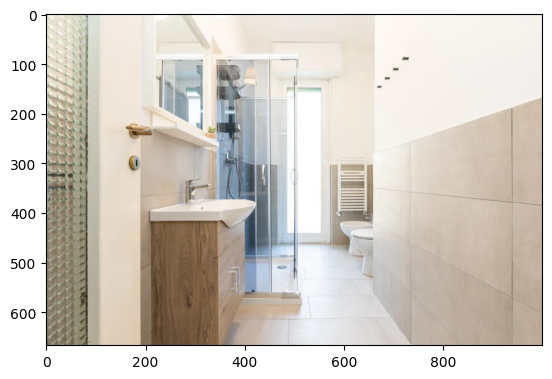

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/images/img_1.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
import pandas as pd
ds_images = pd.DataFrame(list_images)
ds_images.head()

,url,img_file
0,https://www.dovevivo.com/en/rent-studio-bologn...,img_1.jpg
1,https://www.dovevivo.com/en/rent-studio-bologn...,img_2.jpg
2,https://www.dovevivo.com/en/rent-studio-bologn...,img_3.jpg
3,https://www.dovevivo.com/en/rent-studio-bologn...,img_4.jpg
4,https://www.dovevivo.com/en/rent-studio-bologn...,img_5.jpg


In [ ]:
ds_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       5 non-null      object
 1   img_file  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


In [ ]:
ds_images.to_csv("ds_images.csv")

In [ ]:
!zip -r "/content/images.zip" "/content/images/"

  adding: content/images/ (stored 0%)
  adding: content/images/img_1.jpg (stored 0%)
  adding: content/images/img_5.jpg (stored 0%)
  adding: content/images/img_2.jpg (stored 0%)
  adding: content/images/img_4.jpg (deflated 0%)
  adding: content/images/img_3.jpg (deflated 0%)


# Use API to get data from DoveVivo

In [ ]:
import sys
import logging
from selenium.webdriver.remote.remote_connection import LOGGER
LOGGER.setLevel(logging.WARNING)
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver

import requests
from tqdm.notebook import tqdm
import pandas
import pprint
import pandas as pd
import json

[https://docs.python-requests.org/en/master/](https://docs.python-requests.org/en/master/)

> Requests allows you to send HTTP/1.1 requests extremely easily. There’s no need to manually add query strings to your URLs, or to form-encode your POST data. Keep-alive and HTTP connection pooling are 100% automatic, thanks to urllib3.

In [ ]:
room_list = []


# We are scraping 100 pages
for page in tqdm(range(1, 1000)):
  payload = {
      "checkInDate":"2023-06-08T13:00:58.801Z",
      "filters":{"airConditioning": False, "balcony": False,
                 "bikeParking": False,
                 "clothesDryer": False,
                 "concierge": False,
                 "internalSide": False,
                 "lowerFloor": False,
                 "topFloor": False,
                 "privateBathroom": False, "elevator": False,
                 "colivingBuilding": False,"singleRoom": True,
                 "entireStudio": True,
                 "monthlyPrice": {"min":100,"max":1500}
                 },
        "language":"en",
        "positions":[],
        "query": "Milan", "orderBy":"availability_asc","pageIndex": page}
  r = requests.post('https://am-booking-api.azure-api.net/booking/Beds/DV?language=en-us&key=9a0bbdb2-4d56-405d-bafe-7e5ff409dd4c',
                    headers={'Content-type': 'application/json; charset=UTF-8',
                             "User-Agent": "curl/7.64.1",
                             "ocp-apim-subscription-key": "1953d92aa4964b8396c326017fc0e27b"},
                    json=payload)
  # print(r)
  my_rooms = r.json()['items']
  room_list.extend(my_rooms)

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
len(room_list)

396

In [ ]:
r.text

'{"items":[],"flexibleItems":{"items":[{"legalEntity":{"id":"a75cee35-f33b-ec11-b6e5-000d3ab52d1d","name":"DV","entityType":"dvv_legalentity"},"city":{"name":"Milano","code":"MI","nameEn":"Milan","id":"d6387562-e816-e811-a957-000d3a296acd"},"district":{"id":"20ee8f37-1098-e911-a9c0-000d3ab6eff5","name":"Centrale / Garibaldi / Isola","entityType":"clu_quartiere"},"building":{"buildingType":"Bed","nearTransportServices":[{"walkingDistance":69,"description":"Bus 87"}],"pointsOfInterest":[{"poiName":"Stazione Rogoredo","latitude":45.433586201,"longitude":9.2380891079},{"poiName":"Tre Torri","latitude":45.4781401847,"longitude":9.1566753273},{"poiName":"Isola-Porta Nuova","latitude":45.478976797,"longitude":9.1905259202},{"poiName":"Ospedale Niguarda","latitude":45.5080396,"longitude":9.1884795},{"poiName":"Accademia Belle Arti","latitude":45.4720172,"longitude":9.1887518},{"poiName":"Università Bocconi","latitude":45.4488022,"longitude":9.1898607},{"poiName":"Stazione Cadorna","latitude":4

In [ ]:
pprint.pprint(room_list[0:2])

[{'accomodationType': 'Room',
  'address': 'Via Nino Oxilia',
  'availability': {'availableFrom': '2023-06-07T00:00:00+00:00',
                   'availableTo': '2031-03-31T00:00:00+00:00',
                   'bedAvailabilityId': 'bbc59607-d904-ee11-8f6e-0022489fd9a7',
                   'bedCode': 'MI-1322-06-A',
                   'checkInDates': ['2023-06-09T00:00:00+00:00',
                                    '2023-06-12T00:00:00+00:00',
                                    '2023-06-13T00:00:00+00:00',
                                    '2023-06-14T00:00:00+00:00',
                                    '2023-06-15T00:00:00+00:00',
                                    '2023-06-16T00:00:00+00:00',
                                    '2023-06-19T00:00:00+00:00',
                                    '2023-06-20T00:00:00+00:00',
                                    '2023-06-21T00:00:00+00:00',
                                    '2023-06-22T00:00:00+00:00',
                                  

In [ ]:
import pandas as pd
ds_details_full = pd.DataFrame(room_list)
ds_details_full.set_index("id")
ds_details_full.head()

,legalEntity,city,district,building,flat,position,flatFeatures,bedType,roomType,roomFeatures,...,discountedPrice,discountUntil,accomodationType,id,salableOnline,availability,commercialConditions,tenants,name,visibleOnline
0,"{'id': 'a75cee35-f33b-ec11-b6e5-000d3ab52d1d',...","{'name': 'Milano', 'code': 'MI', 'nameEn': 'Mi...","{'id': '20ee8f37-1098-e911-a9c0-000d3ab6eff5',...","{'buildingType': 'Bed', 'nearTransportServices...","{'code': 'MI132200Z', 'type': 'SharedApartment...","{'latitude': 45.4916292, 'longitude': 9.2117258}","{'tenantType': 'NoRestriction', 'tenantConstra...",QueenSize,SingleRoom,"{'size': 12.97, 'balcony': False, 'bathroom': ...",...,490.0,2023-08-31T00:00:00+00:00,Room,a107e2bc-39f3-ed11-8849-002248a3f372,True,"{'bedCode': 'MI-1322-06-A', 'availableTo': '20...",{'contractStartDate': '0001-01-01T00:00:00+00:...,"[{'bedCode': 'MI-1322-04-A', 'gender': 'Male',...",OXILIA 27-SX3PDX-06A,True
1,"{'id': 'a75cee35-f33b-ec11-b6e5-000d3ab52d1d',...","{'name': 'Milano', 'code': 'MI', 'nameEn': 'Mi...","{'id': '28ee8f37-1098-e911-a9c0-000d3ab6eff5',...","{'buildingType': 'Bed', 'nearTransportServices...","{'code': 'MI029600Z', 'type': 'SharedApartment...","{'latitude': 45.45376, 'longitude': 9.13821}","{'tenantType': 'NoRestriction', 'tenantConstra...",Single,SingleRoom,"{'size': 10, 'balcony': True, 'bathroom': False}",...,490.0,2023-08-31T00:00:00+00:00,Room,f1f18391-5558-e811-a95b-000d3ab0cb37,True,"{'bedCode': 'MI-0296-05-A', 'availableTo': '20...",{'contractStartDate': '0001-01-01T00:00:00+00:...,"[{'bedCode': 'MI-0296-01-A', 'gender': 'Male',...",CAVALIERI DI MALTA 4-9PDX-05A,True
2,"{'id': 'a75cee35-f33b-ec11-b6e5-000d3ab52d1d',...","{'name': 'Milano', 'code': 'MI', 'nameEn': 'Mi...","{'id': '28ee8f37-1098-e911-a9c0-000d3ab6eff5',...","{'buildingType': 'Bed', 'nearTransportServices...","{'code': 'MI027300Z', 'type': 'SharedApartment...","{'latitude': 45.45201, 'longitude': 9.14037}","{'tenantType': 'NoRestriction', 'tenantConstra...",QueenSize,SingleRoom,"{'size': 11, 'balcony': False, 'bathroom': False}",...,515.0,2023-08-31T00:00:00+00:00,Room,bfcb2881-5558-e811-a957-000d3ab0cd3c,True,"{'bedCode': 'MI-0273-04-A', 'availableTo': '20...",{'contractStartDate': '0001-01-01T00:00:00+00:...,"[{'bedCode': 'MI-0273-02-A', 'gender': 'Male',...",BARZILAI 5-PRDX-04A,True
3,"{'id': 'a75cee35-f33b-ec11-b6e5-000d3ab52d1d',...","{'name': 'Milano', 'code': 'MI', 'nameEn': 'Mi...","{'id': '28ee8f37-1098-e911-a9c0-000d3ab6eff5',...","{'buildingType': 'Bed', 'nearTransportServices...","{'code': 'MI032600Z', 'type': 'SharedApartment...","{'latitude': 45.4650008, 'longitude': 9.1354142}","{'tenantType': 'NoRestriction', 'tenantConstra...",Single,SingleRoom,"{'size': 11, 'balcony': False, 'bathroom': False}",...,520.0,2023-08-31T00:00:00+00:00,Room,12c69be8-5558-e811-a961-000d3ab0ca26,True,"{'bedCode': 'MI-0326-04-A', 'availableTo': '20...",{'contractStartDate': '0001-01-01T00:00:00+00:...,"[{'bedCode': 'MI-0326-01-A', 'gender': 'Male',...",GULLI 3-3P L-04A,True
4,"{'id': 'a75cee35-f33b-ec11-b6e5-000d3ab52d1d',...","{'name': 'Sesto San Giovanni', 'code': 'Sesto ...","{'id': 'dfb74350-4e30-e911-a98d-000d3ab0c24c',...","{'buildingType': 'Bed', 'nearTransportServices...","{'code': 'MI114400Z', 'type': 'SharedApartment...","{'latitude': 45.541536, 'longitude': 9.235896}","{'tenantType': 'NoRestriction', 'tenantConstra...",Single,DoubleRoom,"{'size': 17.97, 'balcony': True, 'bathroom': F...",...,525.0,2023-08-31T00:00:00+00:00,Room,0a345462-5783-eb11-b1ab-000d3ab9dc22,True,"{'bedCode': 'MI-1144-01-A', 'availableTo': '20...",{'contractStartDate': '0001-01-01T00:00:00+00:...,"[{'bedCode': 'MI-1144-02-A', 'gender': 'Female...",BOCCACCIO 61-SXPTDX-01A,True


In [ ]:
len(ds_details_full)

396

In [ ]:
ds_details_full.to_csv("/content/ds_details_full.csv")

In [ ]:
ds_details_full.to_parquet("/content/ds_details_full.parquet")

# [Advanced] How to use a proxy to hide our connection

Find a free (or other) list of proxies, the scope is to **hide** our connection...

Example: https://free-proxy-list.net/


In [ ]:
PROXY = '135.181.14.45' # FIND A PROXY WHERE HTTPS and GOOGLE ARE ENABLED!!!

In [ ]:
chrome_options.add_argument('--proxy-server=%s' % PROXY)

wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)


<ipython-input-81-661379f171c9>:3: DeprecationWarning: use options instead of chrome_options
  wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)


In [ ]:
wd.set_window_size(1920, 1080)
wd.get("https://whatismyipaddress.com/")

WebDriverException: ignored

Populating the interactive namespace from numpy and matplotlib


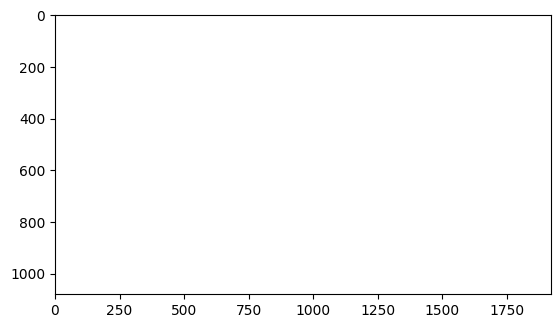

In [ ]:
wd.save_screenshot('screenshot.png')

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/screenshot.png')
imgplot = plt.imshow(img)
plt.show()